In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries 


import pandas as pd


from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time


import sklearn
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style type='text/css'>.CodeMirror{font-size: 17px;</style>"))


/tmp/ipykernel_200812/4171760057.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
# set all configures in one dictonary
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device
conf = { "train": { "device":device,
                    "batch_size": 64,
                    "epoch_amount": 100,
                    "lr": 0.01,
                     "train_period": 20,
                     "predict_period": 2},
        
           "train_test_split": 0.8,
        "API_key": "B4BZJ2ZA0MGDODUA"
       }


In [3]:
# =====================================
# =========download data (my version)============================
# =====================================

# download data from TimeSeries
ts = TimeSeries(key=conf["API_key"], output_format='pandas')
data, _ = ts.get_daily_adjusted(symbol='AAPL', outputsize='full')

# I have date indexes, I want to make from this indexes to columns
data.reset_index(inplace=True)

#print(data1["8. split coefficient"].unque())
data = data.drop(columns=['1. open', '2. high', '3. low', '5. adjusted close', '6. volume', '7. dividend amount'])
data = data.rename(columns = {"date":"date", "4. close": "price", "8. split coefficient": "split"})

k = 1
bool_list = data["split"]!= 1.
divination = np.ones(len(bool_list))
for i in range(len(data["split"])):
    el = bool_list[i]
    if el == False:
        divination[i] /= k
        continue
    else:
        k *= data["split"][i]
        print(k)
        divination[i] /= k

divination = pd.DataFrame(divination)

data["price"] *= divination[divination.keys()[0]]
data["price"] *= data["split"]
data = data.iloc[::-1]
data = data.set_index(np.arange(0, len(data["price"])))


4.0
28.000028000028
56.000056000056
112.000112000112


        date     price  split
0 1999-11-01  0.693035    1.0
1 1999-11-02  0.716517    1.0
2 1999-11-03  0.727678    1.0
5929
<class 'list'>


([<matplotlib.axis.XTick at 0x7f38f6ae8b50>,
  ...],
 [Text(0, 0, '1999-11-01'),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''

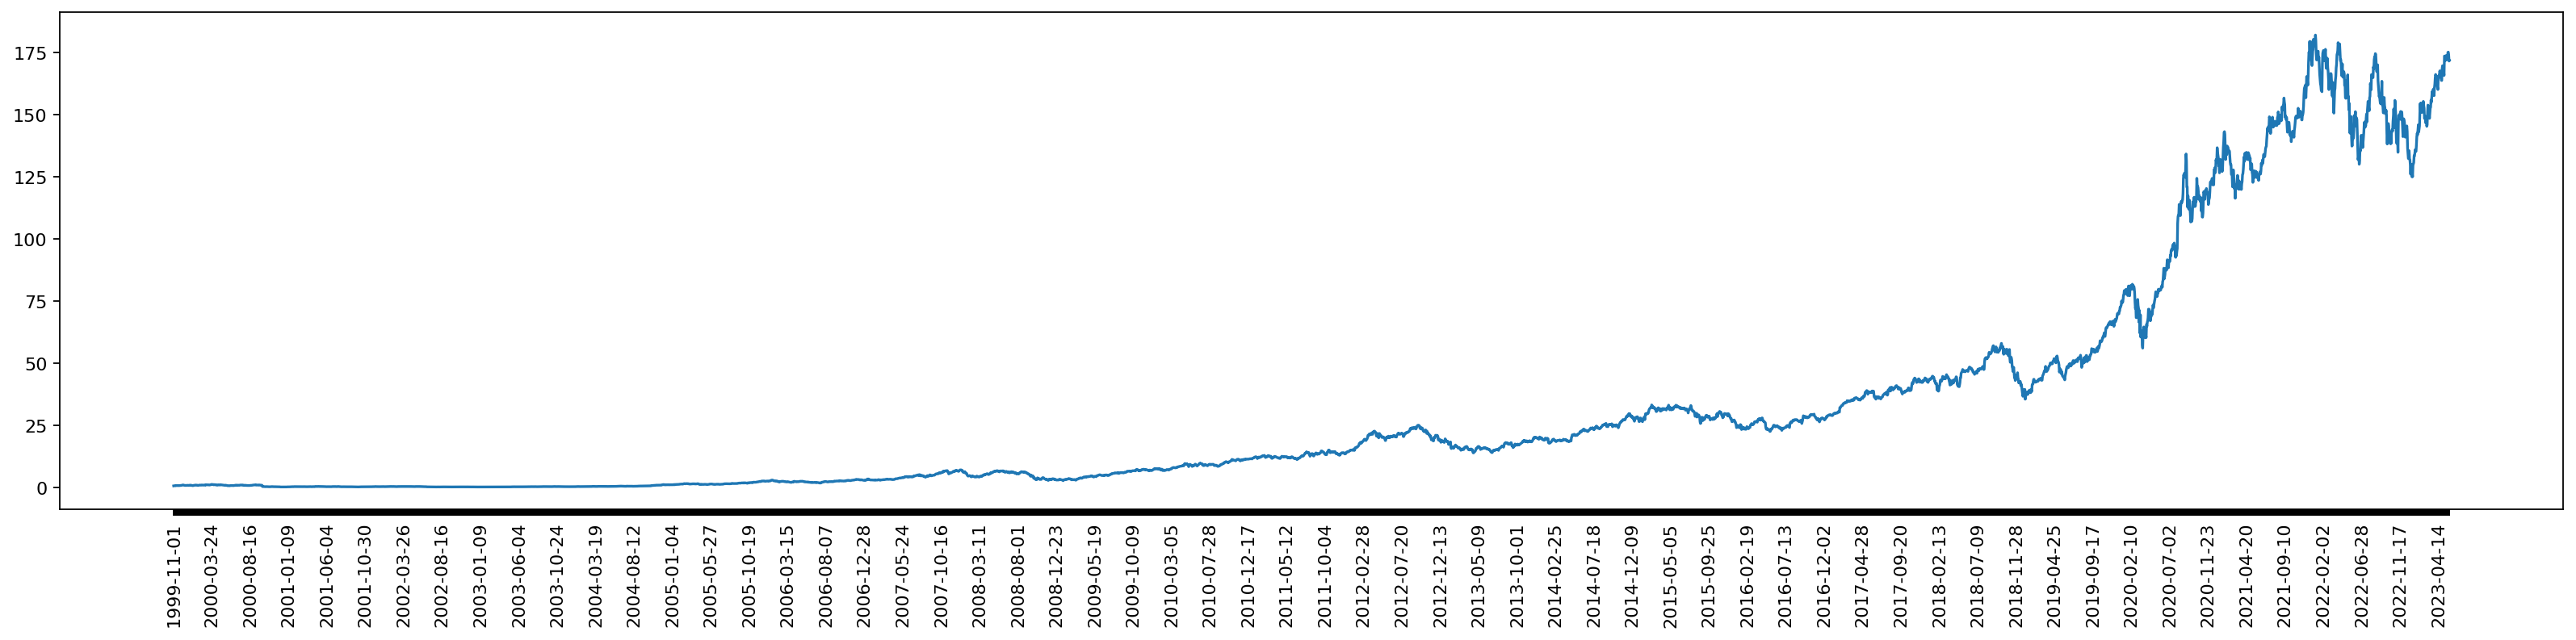

In [4]:
# creating the numpy array of high price 
high_price = data["price"].to_numpy()
data_date =  data["date"].tolist()
data_date = [date.date() for date in data_date]

    

#data1["date"] = data1["date"].iloc[::-1]
print(data.head(3))
print(len(data_date))
print(type(data_date))
fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data["price"])), data["price"], "-")

xticks_value = [data_date[i] if i %100 == 0 else None for i in range(len(data["price"]))  ]
xtv = np.arange(0,len(xticks_value))
plt.xticks(xtv, xticks_value, rotation='vertical')


In [5]:
# download data from TimeSeries
#ts1 = TimeSeries(key=conf_my["API_key"])
#data1, _ = ts1.get_daily_adjusted(symbol='AAPL', outputsize='full')
#data_date = [date for date in data1.keys()]
#data_date.reverse()
#print(data_date)


## Data preparing

in this cell I performed data normalization and test division of the train dataset

1. I made the data normalization by this equation:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

2. I performed divination of the train dataset by **Rolling Window** method

In this project i will train the model to prection ***n *** days price based on the past ***20*** days. 






([<matplotlib.axis.XTick at 0x7f38f02153c0>,
  ...],
 [Text(0, 0, '1999-11-01'),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''

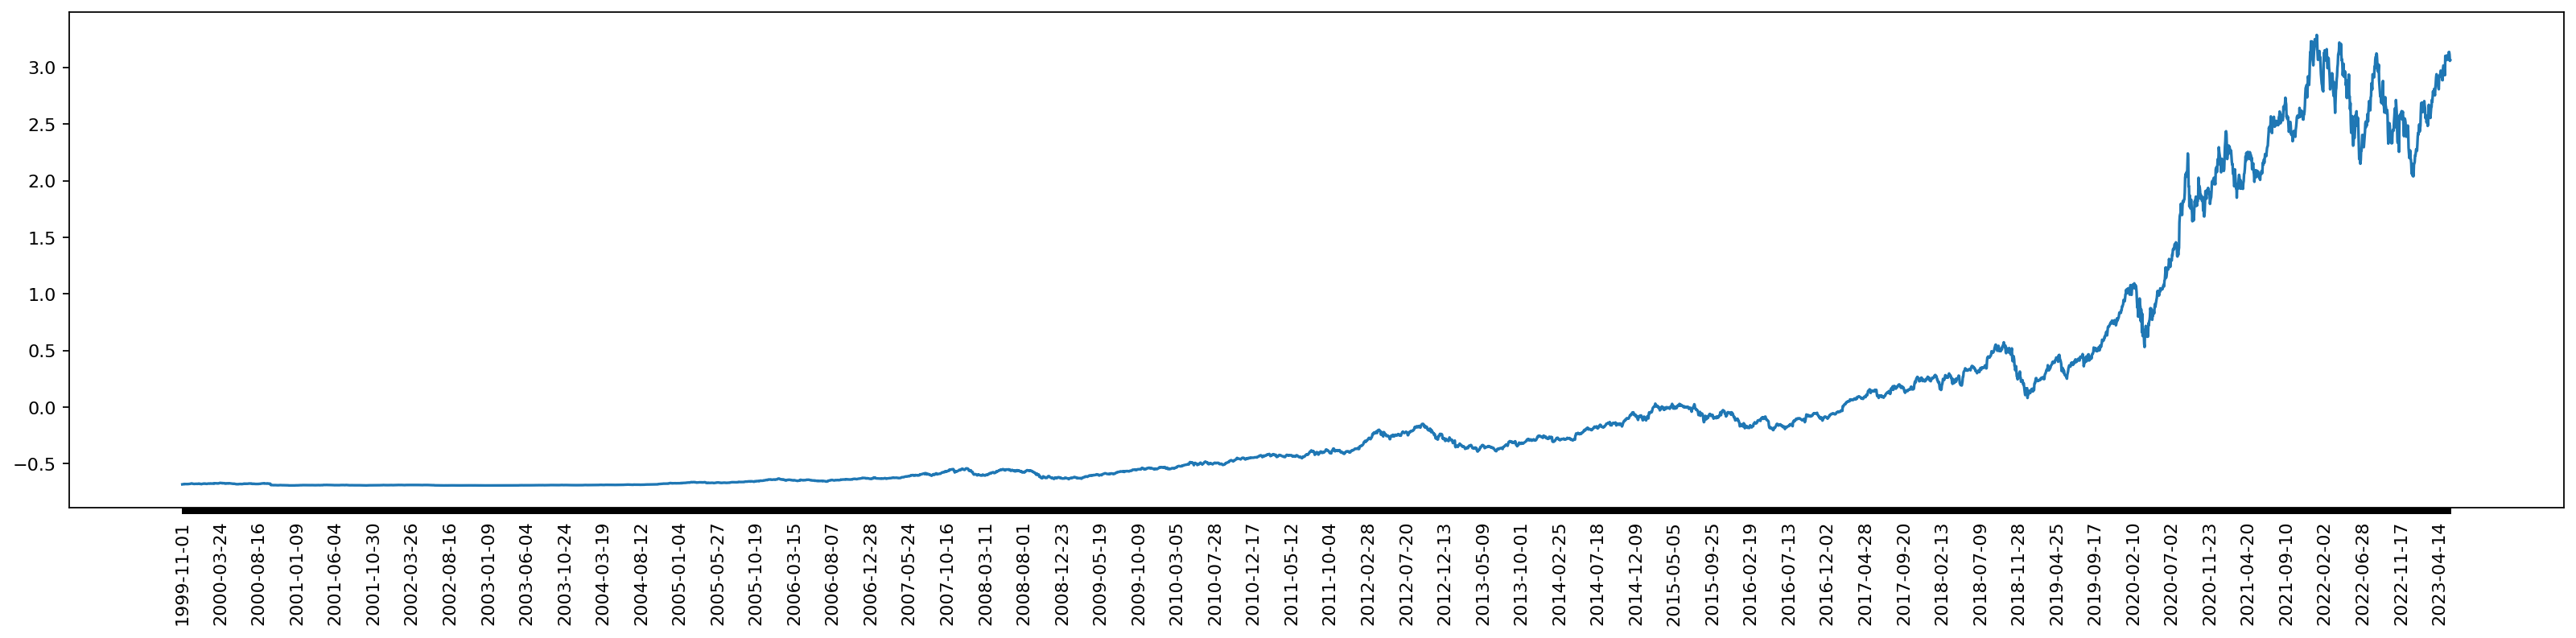

In [6]:
# ======================================
# ================normalization======================
# ======================================

def normalization(x):
    mu = x.mean()
    std = x.std()
    x_normalization = (x - mu) / std
    return x_normalization

data_norm = normalization(high_price)

fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data_norm)), data_norm, "-")

xticks_value = [data_date[i] if i %100 == 0 else None for i in range(len(data_norm))  ]
xtv = np.arange(0,len(xticks_value))
plt.xticks(xtv, xticks_value, rotation='vertical')



In [23]:
# ======================================
# ================test train======================
# ======================================
print(conf.keys())
print(conf["train"].keys())
window_size = 20
step = 7
amount_days_predicted = 3

def RollingWindow(data, window_size, amount_days_predicted):
    x_train = []
    y_train = []
    for i in range(len(data) - window_size - amount_days_predicted):
        x_train.append(data[i:i+window_size])
        y_train.append(data[i+window_size: i + window_size + amount_days_predicted])
    return x_train, y_train
x_train, y_train = RollingWindow(data_norm, window_size, amount_days_predicted)
print(x_train[0])    
print(y_train[0])    


dict_keys(['train', 'train_test_split', 'API_key'])
dict_keys(['device', 'batch_size', 'epoch_amount', 'lr', 'train_period', 'predict_period'])
[-0.68182539 -0.68131133 -0.68106701 -0.68065264 -0.67973594 -0.67816054
 -0.67947989 -0.67912415 -0.67896583 -0.67928443 -0.67951507 -0.67917301
 -0.67935675 -0.67947989 -0.67892869 -0.67928443 -0.67885637 -0.67848891
 -0.67841659 -0.67851432]
[-0.67786735 -0.67685292 -0.6754593 ]


In [16]:
# ======================================
# ================test train======================
# ======================================


# Разбиваем данные на обучающую и тестовую выборки
train_data = data_norm[:-step]
test_data = data_norm[-step:]

# Генерируем временные окна
train_windows = []
for i in range(len(train_data) - window_size):
    train_windows.append(train_data[i:i+window_size])
    
test_windows = []
for i in range(len(test_data) - window_size):
    test_windows.append(test_data[i:i+window_size])

# Преобразуем данные в тензоры PyTorch
train_tensors = [torch.tensor(window) for window in train_windows]
test_tensors = [torch.tensor(window) for window in test_windows]


# Создаем DataLoader для обучающих и тестовых данных
train_loader = DataLoader(train_tensors, batch_size=conf["train"]["batch_size"], shuffle=True)
test_loader = DataLoader(test_tensors, batch_size=conf["train"]["batch_size"], shuffle=False)
    


NameError: name 'size' is not defined

In [ ]:
class LinerModel(nn.Module):
    def __init__(input_size, )
    